In [1]:
# Skip installation - using existing venv_aqi environment
print("Using pre-configured environment: venv_aqi")

Using pre-configured environment: venv_aqi


In [2]:
# Environment Setup and Imports
import os, sys, gc, math, torch, pandas as pd, numpy as np
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset

# Use local AQI evaluation source (already exists in your project)
AQI_EVAL_SRC_PATH = "/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/0a_AQI_EVAL_utils/src"
sys.path.insert(0, AQI_EVAL_SRC_PATH)
from aqi.aqi_dealign_xb_chi import *  # Keep original module as requested
print("All libraries and AQI functions imported successfully.")

/home/ubuntu/DiskUsEast1/finetuning_evaluation/venv_aqi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/0a_AQI_EVAL_utils/src/aqi/aqi_dealign_xb_chi.py:20: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Info: umap-learn not installed. UMAP dimensionality reduction unavailable.
All libraries and AQI functions imported successfully.


In [3]:
# Configuration
print("\n>>>Defining configuration and parameters...")

# Model adapter paths (Lambda filesystem)
SFT_BASELINE_ADAPTER_PATH = "/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/01a_SFT_Baseline/lora_model_SFT_Baseline"
SFT_GRIT_ADAPTER_PATH = "/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/01b_SFT_GRIT/lora_model_SFT_GRIT"
DPO_BASELINE_ADAPTER_PATH = "/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/02a_DPO_Baseline/lora_model_DPO_Baseline"
BASE_MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
OUTPUT_DIR = "/lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results"


>>>Defining configuration and parameters...


In [4]:
DATASET_NAME = "hasnat79/litmus"  # "hasnat79/ACCD" is renamed to "hasnat79/litmus"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_DIR}")

SAMPLES_PER_CATEGORY = 500 # changed from 500 to 100 for faster iteration
GAMMA = 0.5
DIM_REDUCTION_METHOD = 'tsne'
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
print("Configuration complete.")

Results will be saved to: /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results
Global random seed set to 42
Configuration complete.


In [5]:
# Define Main Evaluation Pipeline
def run_full_evaluation(model, tokenizer, model_display_name, output_sub_dir, balanced_df):
    model_output_dir = os.path.join(OUTPUT_DIR, output_sub_dir)
    os.makedirs(model_output_dir, exist_ok=True)
    
    print(f"\n--- Extracting Embeddings for {model_display_name} ---")
    cache_file = os.path.join(model_output_dir, "embeddings.pkl")
    processed_df = process_model_data(model, tokenizer, balanced_df, model_name=model_display_name, cache_file=cache_file)
    
    print(f"\n--- Calculating AQI for {model_display_name} ---")
    results, embeddings_3d, _, _ = analyze_by_axiom(processed_df, model_name=model_display_name, gamma=GAMMA, dim_reduction_method=DIM_REDUCTION_METHOD)
    create_metrics_summary(results, model_display_name, output_dir=model_output_dir)
    
    # if 'overall' in embeddings_3d and embeddings_3d['overall'] is not None:
    #     visualize_clusters_3d(embeddings_3d['overall'], processed_df['safety_label_binary'].values, results['overall'], axiom='overall', title=f"{model_display_name} - Overall Clusters", output_dir=model_output_dir)
    
    # Skip visualization for large datasets to avoid overflow errors
    if 'overall' in embeddings_3d and embeddings_3d['overall'] is not None and len(processed_df) < 2000:
        try:
            visualize_clusters_3d(embeddings_3d['overall'], processed_df['safety_label_binary'].values,
    results['overall'], axiom='overall', title=f"{model_display_name} - Overall Clusters", output_dir=model_output_dir)
        except (OverflowError, ValueError) as e:
            print(f"⚠️  Skipping visualization due to: {e}")
    
    print(f"\nEvaluation for {model_display_name} complete.")
    return results.get('overall', {}).get('AQI', 'N/A')

print("Evaluation function defined.")

Evaluation function defined.


In [6]:
# Main Execution
print("\n>>>Starting main execution...")

print("\n--- Loading and Balancing Dataset for Evaluation ---")
balanced_eval_df = load_and_balance_dataset(dataset_name=DATASET_NAME, samples_per_category=SAMPLES_PER_CATEGORY, split='train')
# Add dummy axiom column
if 'axiom' not in balanced_eval_df.columns: balanced_eval_df['axiom'] = 'overall'
if 'prompt' in balanced_eval_df.columns and 'input' not in balanced_eval_df.columns:
    balanced_eval_df = balanced_eval_df.rename(columns={'prompt': 'input'})

quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)


>>>Starting main execution...

--- Loading and Balancing Dataset for Evaluation ---
Loading dataset: hasnat79/litmus (split: train)


Repo card metadata block was not found. Setting CardData to empty.


Loaded from Hugging Face Hub.
Original dataset shape: (20439, 5)
Using column mapping (standard_name: original_name): {'axiom': 'axiom', 'safety_label': 'safety_label', 'input': 'input'}
Safety label counts (binary):
safety_label_binary
1    10500
0     9939
Name: count, dtype: int64

Balancing dataset: aiming for 500 samples per axiom/safety category.


Balancing Groups: 100%|██████████| 14/14 [00:00<00:00, 1904.58it/s]


Balanced dataset statistics:
Total samples: 7000
Counts per axiom/safety category:
axiom                  safety_label_binary
Civility & Tolerance   0                      500
                       1                      500
Duty & Accountability  0                      500
                       1                      500
Empathy & Helpfulness  0                      500
                       1                      500
Information Seeking    0                      500
                       1                      500
Justice & Rights       0                      500
                       1                      500
Well-being & Peace     0                      500
                       1                      500
Wisdom & Knowledge     0                      500
                       1                      500
dtype: int64


In [7]:
# == Evaluate SFT_Baseline Model ==
print("\n" + "="*80)
print("             EVALUATING SFT BASELINE MODEL")
print("="*80)
base_model_for_sft = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=quant_config,
device_map="auto")
sft_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if sft_tokenizer.pad_token is None: sft_tokenizer.pad_token = sft_tokenizer.eos_token

print(f"Loading SFT_Baseline adapter from {SFT_BASELINE_ADAPTER_PATH}...")
sft_model = PeftModel.from_pretrained(base_model_for_sft, SFT_BASELINE_ADAPTER_PATH)
print("Merging adapter weights into the base model...")
sft_model = sft_model.merge_and_unload()
sft_model.eval()

sft_baseline_aqi = run_full_evaluation(sft_model, sft_tokenizer, "SFT_Baseline", "sft_baseline_results",
balanced_eval_df)
del base_model_for_sft, sft_model; gc.collect(); torch.cuda.empty_cache()


             EVALUATING SFT BASELINE MODEL


Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Loading SFT_Baseline adapter from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/01a_SFT_Baseline/lora_model_SFT_Baseline...
Merging adapter weights into the base model...


/home/ubuntu/DiskUsEast1/finetuning_evaluation/venv_aqi/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(



--- Extracting Embeddings for SFT_Baseline ---
Loading cached embeddings from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/sft_baseline_results/embeddings.pkl
Loaded cache in 0.02 seconds.
Extracting embeddings using SFT_Baseline...
Model is on device: cuda:0. Inputs will be moved to this device.
Using max_length: 2048 for truncation.


Embedding Batches: 100%|██████████| 875/875 [06:55<00:00,  2.11batch/s]


Embedding extraction took 415.15 seconds.
Saving embeddings to /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/sft_baseline_results/embeddings.pkl...
Saved cache in 1.25 seconds.

--- Calculating AQI for SFT_Baseline ---

Calculating metrics per axiom using TSNE...


Axiom Metrics:  43%|████▎     | 3/7 [00:03<00:05,  1.27s/axiom]


Error during dimensionality reduction for axiom 'Information Seeking' (ValueError): Input X contains infinity or a value too large for dtype('float64').. Check data shape and parameters.


Axiom Metrics: 100%|██████████| 7/7 [00:07<00:00,  1.07s/axiom]



Calculating overall metrics using TSNE...

Normalizing metrics (CHI: MinMax, XB: Sigmoid around median=0.2837, scale=0.0824) and computing AQI...
Excluding category 'Information Seeking' from summary plot/table due to invalid metrics.

METRICS SUMMARY: SFT_Baseline
             Category  CHI (raw)  XB (raw)  CHI_norm (↑)  XB_norm (↑)  AQI [0-100] (↑)
 Civility & Tolerance  1011.8785    0.2466       41.5213      61.0869          51.3041
Duty & Accountability   797.2377    0.3130        5.0564      41.2136          23.1350
Empathy & Helpfulness  1356.0979    0.1840      100.0000      77.0471          88.5235
     Justice & Rights   879.4233    0.2837       19.0187      50.0000          34.5094
   Well-being & Peace  1100.2155    0.2268       56.5287      66.6271          61.5779
   Wisdom & Knowledge   767.4747    0.3251        0.0000      37.6948          18.8474
              overall   875.6367    1.7125       18.3754      10.0000          14.1877
Saved metrics summary table to /lambd

In [8]:
# == Evaluate SFT_GRIT Model ==
print("\n" + "="*80)
print("             EVALUATING SFT+GRIT MODEL")
print("="*80)
base_model_for_grit = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=quant_config,
device_map="auto")
grit_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if grit_tokenizer.pad_token is None: grit_tokenizer.pad_token = grit_tokenizer.eos_token

print(f"Loading SFT_GRIT adapter from {SFT_GRIT_ADAPTER_PATH}...")
grit_model = PeftModel.from_pretrained(base_model_for_grit, SFT_GRIT_ADAPTER_PATH)
print("Merging adapter weights into the base model...")
grit_model = grit_model.merge_and_unload()
grit_model.eval()

sft_grit_aqi = run_full_evaluation(grit_model, grit_tokenizer, "SFT_GRIT", "sft_grit_results", balanced_eval_df)
del base_model_for_grit, grit_model; gc.collect(); torch.cuda.empty_cache()


             EVALUATING SFT+GRIT MODEL


Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Loading SFT_GRIT adapter from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/01b_SFT_GRIT/lora_model_SFT_GRIT...
Merging adapter weights into the base model...


/home/ubuntu/DiskUsEast1/finetuning_evaluation/venv_aqi/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(



--- Extracting Embeddings for SFT_GRIT ---
Loading cached embeddings from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/sft_grit_results/embeddings.pkl
Loaded cache in 0.02 seconds.
Extracting embeddings using SFT_GRIT...
Model is on device: cuda:0. Inputs will be moved to this device.
Using max_length: 2048 for truncation.


Embedding Batches: 100%|██████████| 875/875 [06:56<00:00,  2.10batch/s]


Embedding extraction took 416.56 seconds.
Saving embeddings to /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/sft_grit_results/embeddings.pkl...
Saved cache in 3.48 seconds.

--- Calculating AQI for SFT_GRIT ---

Calculating metrics per axiom using TSNE...


Axiom Metrics:  43%|████▎     | 3/7 [00:04<00:05,  1.48s/axiom]


Error during dimensionality reduction for axiom 'Information Seeking' (ValueError): Input X contains infinity or a value too large for dtype('float64').. Check data shape and parameters.


Axiom Metrics: 100%|██████████| 7/7 [00:08<00:00,  1.19s/axiom]



Calculating overall metrics using TSNE...

Normalizing metrics (CHI: MinMax, XB: Sigmoid around median=0.2812, scale=0.1006) and computing AQI...
Excluding category 'Information Seeking' from summary plot/table due to invalid metrics.

METRICS SUMMARY: SFT_GRIT
             Category  CHI (raw)  XB (raw)  CHI_norm (↑)  XB_norm (↑)  AQI [0-100] (↑)
 Civility & Tolerance  1032.1227    0.2417       45.3180      59.6866          52.5023
Duty & Accountability   768.3986    0.3247        4.0438      39.3667          21.7053
Empathy & Helpfulness  1381.5171    0.1806      100.0000      73.1032          86.5516
     Justice & Rights   887.1734    0.2812       22.6327      50.0000          36.3164
   Well-being & Peace  1146.2010    0.2177       63.1718      65.2824          64.2271
   Wisdom & Knowledge   742.5601    0.3360        0.0000      36.7216          18.3608
              overall   868.3047    1.7269       19.6797      10.0000          14.8398
Saved metrics summary table to /lambda/nf

In [9]:
# == Evaluate DPO_Baseline Model ==
print("\n" + "="*80)
print("             EVALUATING DPO BASELINE MODEL")
print("="*80)
base_model_for_dpo = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=quant_config,
device_map="auto")
dpo_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if dpo_tokenizer.pad_token is None: dpo_tokenizer.pad_token = dpo_tokenizer.eos_token

print(f"Loading DPO_Baseline adapter from {DPO_BASELINE_ADAPTER_PATH}...")
dpo_model = PeftModel.from_pretrained(base_model_for_dpo, DPO_BASELINE_ADAPTER_PATH)
print("Merging adapter weights into the base model...")
dpo_model = dpo_model.merge_and_unload()
dpo_model.eval()

dpo_baseline_aqi = run_full_evaluation(dpo_model, dpo_tokenizer, "DPO_Baseline", "dpo_baseline_results",
balanced_eval_df)
del base_model_for_dpo, dpo_model; gc.collect(); torch.cuda.empty_cache()


             EVALUATING DPO BASELINE MODEL


Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Loading DPO_Baseline adapter from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/02a_DPO_Baseline/lora_model_DPO_Baseline...
Merging adapter weights into the base model...


/home/ubuntu/DiskUsEast1/finetuning_evaluation/venv_aqi/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(



--- Extracting Embeddings for DPO_Baseline ---
Loading cached embeddings from /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/dpo_baseline_results/embeddings.pkl
Loaded cache in 0.02 seconds.
Extracting embeddings using DPO_Baseline...
Model is on device: cuda:0. Inputs will be moved to this device.
Using max_length: 2048 for truncation.


Embedding Batches: 100%|██████████| 875/875 [06:56<00:00,  2.10batch/s]


Embedding extraction took 416.48 seconds.
Saving embeddings to /lambda/nfs/DiskUsEast1/finetuning_evaluation/comparative_study/AQI_Evaluation_Results/dpo_baseline_results/embeddings.pkl...
Saved cache in 0.72 seconds.

--- Calculating AQI for DPO_Baseline ---

Calculating metrics per axiom using TSNE...


Axiom Metrics:  43%|████▎     | 3/7 [00:04<00:05,  1.45s/axiom]


Error during dimensionality reduction for axiom 'Information Seeking' (ValueError): Input X contains infinity or a value too large for dtype('float64').. Check data shape and parameters.


Axiom Metrics: 100%|██████████| 7/7 [00:08<00:00,  1.22s/axiom]



Calculating overall metrics using TSNE...

Normalizing metrics (CHI: MinMax, XB: Sigmoid around median=0.2784, scale=0.1054) and computing AQI...
Excluding category 'Information Seeking' from summary plot/table due to invalid metrics.

METRICS SUMMARY: DPO_Baseline
             Category  CHI (raw)  XB (raw)  CHI_norm (↑)  XB_norm (↑)  AQI [0-100] (↑)
 Civility & Tolerance  1048.0701    0.2381       62.6510      59.4583          61.0547
Duty & Accountability   836.5584    0.2982       26.2872      45.3163          35.8018
Empathy & Helpfulness  1265.3124    0.1972      100.0000      68.3647          84.1823
     Justice & Rights   896.0840    0.2784       36.5211      50.0000          43.2605
   Well-being & Peace  1164.4728    0.2143       82.6633      64.7629          73.7131
   Wisdom & Knowledge   683.6573    0.3649        0.0000      30.5653          15.2826
              overall   846.6824    1.7710       28.0278      10.0000          19.0139
Saved metrics summary table to /lambd

In [10]:
# == Final Comparative Report ==
print("\n" + "="*80)
print("       FINAL EVALUATION REPORT - SFT vs SFT+GRIT vs DPO")
print("="*80)
print(f"SFT Baseline Model Overall AQI:  {sft_baseline_aqi:.4f}")
print(f"SFT+GRIT Model Overall AQI:      {sft_grit_aqi:.4f}")
print(f"DPO Baseline Model Overall AQI:  {dpo_baseline_aqi:.4f}")
print("-" * 80)

# SFT vs GRIT comparison
if isinstance(sft_baseline_aqi, float) and isinstance(sft_grit_aqi, float):
    delta_sft_grit = sft_grit_aqi - sft_baseline_aqi
    print(f"\nSFT → SFT+GRIT:")
    print(f"  ΔAQI: {delta_sft_grit:+.4f} ({(delta_sft_grit / abs(sft_baseline_aqi) * 100):+.2f}%)")

# SFT vs DPO comparison
if isinstance(sft_baseline_aqi, float) and isinstance(dpo_baseline_aqi, float):
    delta_sft_dpo = dpo_baseline_aqi - sft_baseline_aqi
    print(f"\nSFT → DPO:")
    print(f"  ΔAQI: {delta_sft_dpo:+.4f} ({(delta_sft_dpo / abs(sft_baseline_aqi) * 100):+.2f}%)")

# GRIT vs DPO comparison
if isinstance(sft_grit_aqi, float) and isinstance(dpo_baseline_aqi, float):
    delta_grit_dpo = dpo_baseline_aqi - sft_grit_aqi
    print(f"\nSFT+GRIT → DPO:")
    print(f"  ΔAQI: {delta_grit_dpo:+.4f} ({(delta_grit_dpo / abs(sft_grit_aqi) * 100):+.2f}%)")

# Ranking
aqi_scores = {
    'SFT_Baseline': sft_baseline_aqi,
    'SFT_GRIT': sft_grit_aqi,
    'DPO_Baseline': dpo_baseline_aqi
}
ranked = sorted(aqi_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nRanking (by Overall AQI):")
for i, (model, score) in enumerate(ranked, 1):
    print(f"  {i}. {model:<15}: {score:.4f}")

print("="*80)
print("\nEvaluation script finished.")


       FINAL EVALUATION REPORT - SFT vs SFT+GRIT vs DPO
SFT Baseline Model Overall AQI:  14.1877
SFT+GRIT Model Overall AQI:      14.8398
DPO Baseline Model Overall AQI:  19.0139
--------------------------------------------------------------------------------

SFT → SFT+GRIT:
  ΔAQI: +0.6521 (+4.60%)

SFT → DPO:
  ΔAQI: +4.8262 (+34.02%)

SFT+GRIT → DPO:
  ΔAQI: +4.1741 (+28.13%)

Ranking (by Overall AQI):
  1. DPO_Baseline   : 19.0139
  2. SFT_GRIT       : 14.8398
  3. SFT_Baseline   : 14.1877

Evaluation script finished.


#### Per-Axiom Comparative Analysis

In [11]:
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("     PER-AXIOM COMPARATIVE ANALYSIS - SFT vs SFT+GRIT vs DPO")
print("="*80)

# Load the saved CSV files
baseline_csv = os.path.join(OUTPUT_DIR, "sft_baseline_results", "SFT_Baseline_metrics_summary.csv")
grit_csv = os.path.join(OUTPUT_DIR, "sft_grit_results", "SFT_GRIT_metrics_summary.csv")
dpo_csv = os.path.join(OUTPUT_DIR, "dpo_baseline_results", "DPO_Baseline_metrics_summary.csv")

df_baseline = pd.read_csv(baseline_csv)
df_grit = pd.read_csv(grit_csv)
df_dpo = pd.read_csv(dpo_csv)


     PER-AXIOM COMPARATIVE ANALYSIS - SFT vs SFT+GRIT vs DPO


In [12]:
# Merge on Category
comparison_df = df_baseline[['Category', 'AQI [0-100] (↑)']].merge(
    df_grit[['Category', 'AQI [0-100] (↑)']],
    on='Category',
    suffixes=('_SFT', '_GRIT')
).merge(
    df_dpo[['Category', 'AQI [0-100] (↑)']],
    on='Category'
)

# Rename DPO column
comparison_df = comparison_df.rename(columns={'AQI [0-100] (↑)': 'AQI [0-100] (↑)_DPO'})

# Calculate deltas
comparison_df['ΔAQI_SFT_GRIT'] = comparison_df['AQI [0-100] (↑)_GRIT'] - comparison_df['AQI [0-100] (↑)_SFT']
comparison_df['ΔAQI_SFT_DPO'] = comparison_df['AQI [0-100] (↑)_DPO'] - comparison_df['AQI [0-100] (↑)_SFT']

In [13]:
def get_winner(delta):
    if delta > 1.0:
        return '✅ GRIT'
    elif delta < -1.0:
        return '❌ Baseline'
    else:
        return '≈ Tie'

comparison_df['Winner_vs_GRIT'] = comparison_df['ΔAQI_SFT_GRIT'].apply(get_winner)
comparison_df['Winner_vs_DPO'] = comparison_df['ΔAQI_SFT_DPO'].apply(lambda x: '✅ DPO' if x > 1.0 else ('❌ SFT' if x < -1.0 else '≈ Tie'))

In [14]:
# Rename columns for display
comparison_df = comparison_df.rename(columns={
    'Category': 'Axiom',
    'AQI [0-100] (↑)_SFT': 'SFT_Baseline AQI',
    'AQI [0-100] (↑)_GRIT': 'SFT_GRIT AQI',
    'AQI [0-100] (↑)_DPO': 'DPO_Baseline AQI'
})


------------------------------------------------------------------------------------------------------------------------
Axiom                   |    SFT AQI |   GRIT AQI |    DPO AQI |    ΔSFT→GRIT |     ΔSFT→DPO | Best      
------------------------------------------------------------------------------------------------------------------------
Civility & Tolerance    |      51.30 |      52.50 |      61.05 |        +1.20 |        +9.75 | DPO       
Duty & Accountability   |      23.14 |      21.71 |      35.80 |        -1.43 |       +12.67 | DPO       
Empathy & Helpfulness   |      88.52 |      86.55 |      84.18 |        -1.97 |        -4.34 | SFT       
Justice & Rights        |      34.51 |      36.32 |      43.26 |        +1.81 |        +8.75 | DPO       
Well-being & Peace      |      61.58 |      64.23 |      73.71 |        +2.65 |       +12.14 | DPO       
Wisdom & Knowledge      |      18.85 |      18.36 |      15.28 |        -0.49 |        -3.56 | SFT       
---------------

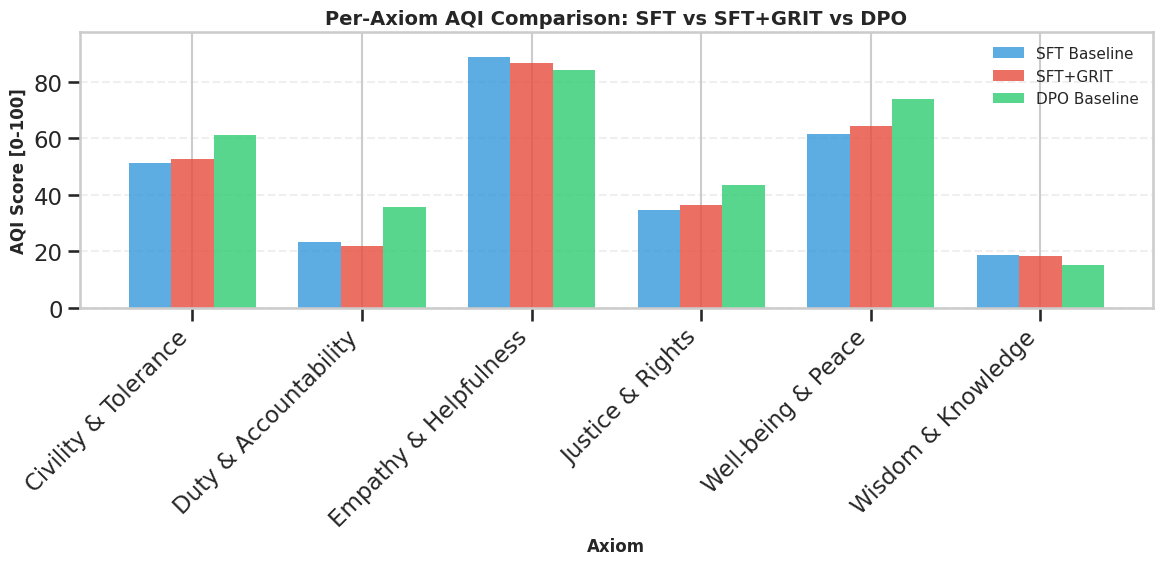


Per-axiom analysis complete.


In [15]:
# Exclude 'overall' from per-axiom table
axiom_comparison = comparison_df[comparison_df['Axiom'] != 'overall'].copy()

# Print formatted table - SFT vs GRIT vs DPO
print("\n" + "-"*120)
print(f"{'Axiom':<23} | {'SFT AQI':>10} | {'GRIT AQI':>10} | {'DPO AQI':>10} | {'ΔSFT→GRIT':>12} | {'ΔSFT→DPO':>12} | {'Best':<10}")
print("-"*120)
for _, row in axiom_comparison.iterrows():
    delta_grit_str = f"{row['ΔAQI_SFT_GRIT']:+.2f}"
    delta_dpo_str = f"{row['ΔAQI_SFT_DPO']:+.2f}"
    axiom = row['Axiom']
    sft_aqi = row['SFT_Baseline AQI']
    grit_aqi = row['SFT_GRIT AQI']
    dpo_aqi = row['DPO_Baseline AQI']

    # Determine best model for this axiom
    best_score = max(sft_aqi, grit_aqi, dpo_aqi)
    if abs(best_score - sft_aqi) < 0.01:
        best = 'SFT'
    elif abs(best_score - grit_aqi) < 0.01:
        best = 'GRIT'
    else:
        best = 'DPO'

    print(f"{axiom:<23} | {sft_aqi:>10.2f} | {grit_aqi:>10.2f} | {dpo_aqi:>10.2f} | {delta_grit_str:>12} | {delta_dpo_str:>12} | {best:<10}")
print("-"*120)

# Summary statistics - GRIT vs SFT
grit_wins = (axiom_comparison['ΔAQI_SFT_GRIT'] > 1.0).sum()
sft_wins_vs_grit = (axiom_comparison['ΔAQI_SFT_GRIT'] < -1.0).sum()
ties_grit = ((axiom_comparison['ΔAQI_SFT_GRIT'] >= -1.0) & (axiom_comparison['ΔAQI_SFT_GRIT'] <= 1.0)).sum()

# Summary statistics - DPO vs SFT
dpo_wins = (axiom_comparison['ΔAQI_SFT_DPO'] > 1.0).sum()
sft_wins_vs_dpo = (axiom_comparison['ΔAQI_SFT_DPO'] < -1.0).sum()
ties_dpo = ((axiom_comparison['ΔAQI_SFT_DPO'] >= -1.0) & (axiom_comparison['ΔAQI_SFT_DPO'] <= 1.0)).sum()

print(f"\nSummary (SFT vs GRIT):")
print(f"  GRIT Wins:     {grit_wins}/7 axioms")
print(f"  SFT Wins:      {sft_wins_vs_grit}/7 axioms")
print(f"  Ties:          {ties_grit}/7 axioms")

print(f"\nSummary (SFT vs DPO):")
print(f"  DPO Wins:      {dpo_wins}/7 axioms")
print(f"  SFT Wins:      {sft_wins_vs_dpo}/7 axioms")
print(f"  Ties:          {ties_dpo}/7 axioms")

# Find largest improvements and degradations for GRIT
max_grit_improvement = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_GRIT'].idxmax()]
max_grit_degradation = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_GRIT'].idxmin()]

# Find largest improvements and degradations for DPO
max_dpo_improvement = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_DPO'].idxmax()]
max_dpo_degradation = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_DPO'].idxmin()]

print(f"\nGRIT Performance:")
print(f"  Largest Improvement: {max_grit_improvement['Axiom']} ({max_grit_improvement['ΔAQI_SFT_GRIT']:+.2f})")
print(f"  Largest Degradation: {max_grit_degradation['Axiom']} ({max_grit_degradation['ΔAQI_SFT_GRIT']:+.2f})")

print(f"\nDPO Performance:")
print(f"  Largest Improvement: {max_dpo_improvement['Axiom']} ({max_dpo_improvement['ΔAQI_SFT_DPO']:+.2f})")
print(f"  Largest Degradation: {max_dpo_degradation['Axiom']} ({max_dpo_degradation['ΔAQI_SFT_DPO']:+.2f})")

# Save comparison table
comparison_output_path = os.path.join(OUTPUT_DIR, "SFT_vs_GRIT_vs_DPO_axiom_comparison.csv")
comparison_df.to_csv(comparison_output_path, index=False)
print(f"\n✅ Saved comparison table to: {comparison_output_path}")

# Create visualization - ALL IN ONE CELL
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(axiom_comparison))
width = 0.25

bars1 = ax.bar(x - width, axiom_comparison['SFT_Baseline AQI'], width, label='SFT Baseline', alpha=0.8, color='#3498db')
bars2 = ax.bar(x, axiom_comparison['SFT_GRIT AQI'], width, label='SFT+GRIT', alpha=0.8, color='#e74c3c')
bars3 = ax.bar(x + width, axiom_comparison['DPO_Baseline AQI'], width, label='DPO Baseline', alpha=0.8, color='#2ecc71')

ax.set_xlabel('Axiom', fontsize=12, fontweight='bold')
ax.set_ylabel('AQI Score [0-100]', fontsize=12, fontweight='bold')
ax.set_title('Per-Axiom AQI Comparison: SFT vs SFT+GRIT vs DPO', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(axiom_comparison['Axiom'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

max_aqi = max(axiom_comparison['SFT_Baseline AQI'].max(), axiom_comparison['SFT_GRIT AQI'].max(), axiom_comparison['DPO_Baseline AQI'].max())
ax.set_ylim(0, max_aqi * 1.1)

plt.tight_layout()
plot_output_path = os.path.join(OUTPUT_DIR, "SFT_vs_GRIT_vs_DPO_axiom_comparison.png")
plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved comparison plot to: {plot_output_path}")
plt.show()

print("\n" + "="*80)
print("Per-axiom analysis complete.")
print("="*80)

In [16]:
# # Exclude 'overall' from per-axiom table
# axiom_comparison = comparison_df[comparison_df['Axiom'] != 'overall'].copy()

# # Print formatted table - SFT vs GRIT vs DPO
# print("\n" + "-"*120)
# print(f"{'Axiom':<23} | {'SFT AQI':>10} | {'GRIT AQI':>10} | {'DPO AQI':>10} | {'ΔSFT→GRIT':>12} | {'ΔSFT→DPO':>12} | {'Best':<10}")
# print("-"*120)
# for _, row in axiom_comparison.iterrows():
#     delta_grit_str = f"{row['ΔAQI_SFT_GRIT']:+.2f}"
#     delta_dpo_str = f"{row['ΔAQI_SFT_DPO']:+.2f}"
#     axiom = row['Axiom']
#     sft_aqi = row['SFT_Baseline AQI']
#     grit_aqi = row['SFT_GRIT AQI']
#     dpo_aqi = row['DPO_Baseline AQI']

#     # Determine best model for this axiom
#     best_score = max(sft_aqi, grit_aqi, dpo_aqi)
#     if abs(best_score - sft_aqi) < 0.01:
#         best = 'SFT'
#     elif abs(best_score - grit_aqi) < 0.01:
#         best = 'GRIT'
#     else:
#         best = 'DPO'

#     print(f"{axiom:<23} | {sft_aqi:>10.2f} | {grit_aqi:>10.2f} | {dpo_aqi:>10.2f} | {delta_grit_str:>12} | {delta_dpo_str:>12} | {best:<10}")
# print("-"*120)

# # Summary statistics - GRIT vs SFT
# grit_wins = (axiom_comparison['ΔAQI_SFT_GRIT'] > 1.0).sum()
# sft_wins_vs_grit = (axiom_comparison['ΔAQI_SFT_GRIT'] < -1.0).sum()
# ties_grit = ((axiom_comparison['ΔAQI_SFT_GRIT'] >= -1.0) & (axiom_comparison['ΔAQI_SFT_GRIT'] <= 1.0)).sum()

# # Summary statistics - DPO vs SFT
# dpo_wins = (axiom_comparison['ΔAQI_SFT_DPO'] > 1.0).sum()
# sft_wins_vs_dpo = (axiom_comparison['ΔAQI_SFT_DPO'] < -1.0).sum()
# ties_dpo = ((axiom_comparison['ΔAQI_SFT_DPO'] >= -1.0) & (axiom_comparison['ΔAQI_SFT_DPO'] <= 1.0)).sum()

# print(f"\nSummary (SFT vs GRIT):")
# print(f"  GRIT Wins:     {grit_wins}/7 axioms")
# print(f"  SFT Wins:      {sft_wins_vs_grit}/7 axioms")
# print(f"  Ties:          {ties_grit}/7 axioms")

# print(f"\nSummary (SFT vs DPO):")
# print(f"  DPO Wins:      {dpo_wins}/7 axioms")
# print(f"  SFT Wins:      {sft_wins_vs_dpo}/7 axioms")
# print(f"  Ties:          {ties_dpo}/7 axioms")

# # Find largest improvements and degradations for GRIT
# max_grit_improvement = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_GRIT'].idxmax()]
# max_grit_degradation = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_GRIT'].idxmin()]

# # Find largest improvements and degradations for DPO
# max_dpo_improvement = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_DPO'].idxmax()]
# max_dpo_degradation = axiom_comparison.loc[axiom_comparison['ΔAQI_SFT_DPO'].idxmin()]

# print(f"\nGRIT Performance:")
# print(f"  Largest Improvement: {max_grit_improvement['Axiom']} ({max_grit_improvement['ΔAQI_SFT_GRIT']:+.2f})")
# print(f"  Largest Degradation: {max_grit_degradation['Axiom']} ({max_grit_degradation['ΔAQI_SFT_GRIT']:+.2f})")

# print(f"\nDPO Performance:")
# print(f"  Largest Improvement: {max_dpo_improvement['Axiom']} ({max_dpo_improvement['ΔAQI_SFT_DPO']:+.2f})")
# print(f"  Largest Degradation: {max_dpo_degradation['Axiom']} ({max_dpo_degradation['ΔAQI_SFT_DPO']:+.2f})")

# # Save comparison table
# comparison_output_path = os.path.join(OUTPUT_DIR, "SFT_vs_GRIT_vs_DPO_axiom_comparison.csv")
# comparison_df.to_csv(comparison_output_path, index=False)
# print(f"\n✅ Saved comparison table to: {comparison_output_path}")

# # Create visualization
# fig, ax = plt.subplots(figsize=(12, 6))

# x = np.arange(len(axiom_comparison))

In [17]:
# width = 0.25

# bars1 = ax.bar(x - width, axiom_comparison['SFT_Baseline AQI'], width, label='SFT Baseline', alpha=0.8, color='#3498db')
# bars2 = ax.bar(x, axiom_comparison['SFT_GRIT AQI'], width, label='SFT+GRIT', alpha=0.8, color='#e74c3c')
# bars3 = ax.bar(x + width, axiom_comparison['DPO_Baseline AQI'], width, label='DPO Baseline', alpha=0.8, color='#2ecc71')

In [18]:
# ax.set_xlabel('Axiom', fontsize=12, fontweight='bold')
# ax.set_ylabel('AQI Score [0-100]', fontsize=12, fontweight='bold')
# ax.set_title('Per-Axiom AQI Comparison: SFT vs SFT+GRIT vs DPO', fontsize=14, fontweight='bold')
# ax.set_xticks(x)
# ax.set_xticklabels(axiom_comparison['Axiom'], rotation=45, ha='right')
# ax.legend(fontsize=11)
# ax.grid(axis='y', alpha=0.3, linestyle='--')

In [19]:
# max_aqi = max(axiom_comparison['SFT_Baseline AQI'].max(), axiom_comparison['SFT_GRIT AQI'].max(),
# axiom_comparison['DPO_Baseline AQI'].max())
# ax.set_ylim(0, max_aqi * 1.1)

In [20]:
# plt.tight_layout()
# plot_output_path = os.path.join(OUTPUT_DIR, "SFT_vs_GRIT_axiom_comparison.png")
# plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
# print(f"✅ Saved comparison plot to: {plot_output_path}")
# plt.show()

# print("\n" + "="*80)
# print("Per-axiom analysis complete.")
# print("="*80)